In [62]:
# imports
import numpy as np
import pandas as pd
import json

# modelling
from sklearn import datasets
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score, average_precision_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset split: 56000 train rows 56000 label rows
Dataset split: 14000 test rows 14000 label rows


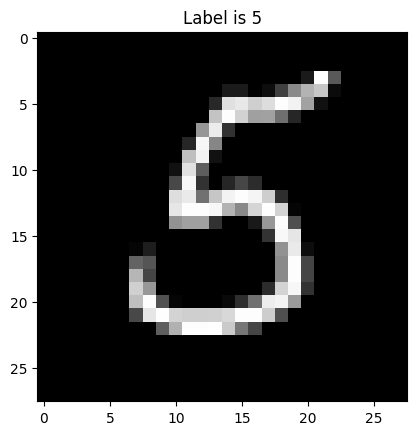

In [63]:
# Initialize
mnist = datasets.fetch_openml("mnist_784")
X, y = mnist.data, mnist.target

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# digits = load_digits()
print(f"Dataset split: {len(x_train)} train rows",
          f"{len(y_train)} label rows")

print(f"Dataset split: {len(x_test)} test rows",
          f"{len(y_test)} label rows")

point = np.array(x_train.iloc[0], dtype='uint8')
point = point.reshape((28, 28))

plt.title('Label is {label}'.format(label=y_train.iloc[0]))
plt.imshow(point, cmap='gray')
plt.show()

In [64]:
print(x_train.shape)
print(x_test.shape)

(56000, 784)
(14000, 784)


In [65]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# convert labels to integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [66]:
# Create and train an Isolation Forest model
model = IsolationForest(contamination=0.01, n_estimators=50, random_state=42)
model.fit(x_train)

IsolationForest(contamination=0.01, n_estimators=50, random_state=42)

In [67]:
prediction = model.predict(x_test)

In [68]:
print(prediction)

[1 1 1 ... 1 1 1]


In [69]:
# Get anomaly indexes
anomaly_indexes = np.where(prediction == -1)[0]

# Display the anomaly indices
print("Anomaly Indexes:", anomaly_indexes)
print(len(anomaly_indexes))

Anomaly Indexes: [   83   159   205   239   337   386   676   695   773   830   864   881
   919   993   995  1111  1147  1182  1232  1593  1743  1780  1803  1836
  1942  2204  2329  2541  2547  2555  2582  2618  2622  3170  3324  3450
  3515  3611  3733  3751  3934  4063  4106  4373  4395  4428  4487  4566
  4574  4581  4693  4832  5001  5104  5203  5370  5735  5748  5756  5775
  5921  5955  6121  6290  6425  6520  6584  6740  6809  6866  6934  6947
  7388  7485  7556  7611  7670  7749  7994  8093  8141  8155  8269  8353
  8369  8517  8567  8798  8859  9004  9038  9129  9144  9181  9184  9293
  9483  9664  9739  9994 10357 10412 10612 10626 10890 10909 11080 11202
 11261 11334 11341 11395 11449 11723 11853 11888 11970 12091 12460 12487
 12592 12620 12758 12775 12804 12850 12989 12999 13267 13325 13420 13431
 13596 13745 13982 13996]
136


In [70]:
# Convert the list of anomaly indexes to a NumPy array
anomaly_indexes_array = np.array(anomaly_indexes)

# Extract labels of anomalies
anomaly_labels = y_test.iloc[anomaly_indexes_array]

# Display the anomaly labels
print("Anomaly Labels:", anomaly_labels)

Anomaly Labels: 48463    2
2009     0
44455    2
13902    4
48263    0
        ..
53100    5
63517    4
61170    8
37794    4
16276    5
Name: class, Length: 136, dtype: int32


In [71]:
# Extract anomaly images from the test set
anomalies = x_test.iloc[anomaly_indexes_array]

print(len(anomalies))

136


In [72]:
# create a dict of indexes and labels
anomaly_dict = dict(zip(map(int, anomaly_indexes), anomaly_labels))

In [73]:
# write to json file
json_filename = "anomalies.json"
with open(json_filename, 'w') as json_file:
    json.dump(anomaly_dict, json_file)

print(f"Anomaly dictionary saved to {json_filename}")

Anomaly dictionary saved to anomalies.json


In [74]:
# Reshape the test data for plotting
x_test_reshaped = x_test.values.reshape(-1, 28, 28)

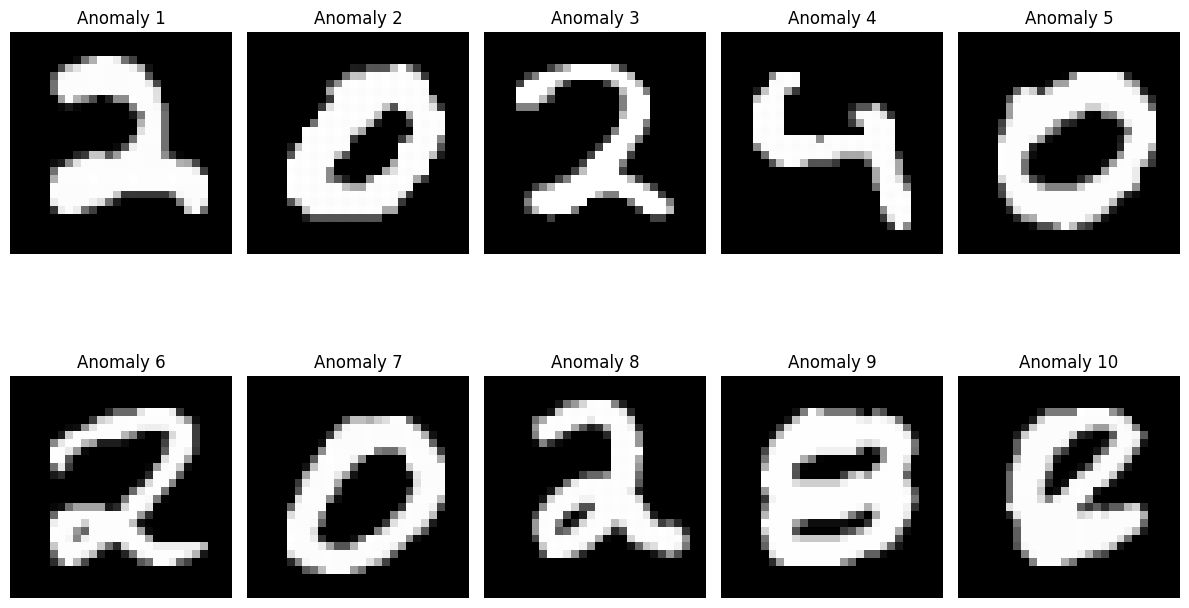

In [75]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_reshaped[idx], cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [76]:
# Get anomaly scores
anomaly_scores = model.decision_function(x_test)

# Display anomaly scores
print("Anomaly Scores:")
print(anomaly_scores)

Anomaly Scores:
[0.01917661 0.1495907  0.07733886 ... 0.15290835 0.14920114 0.17707088]


c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


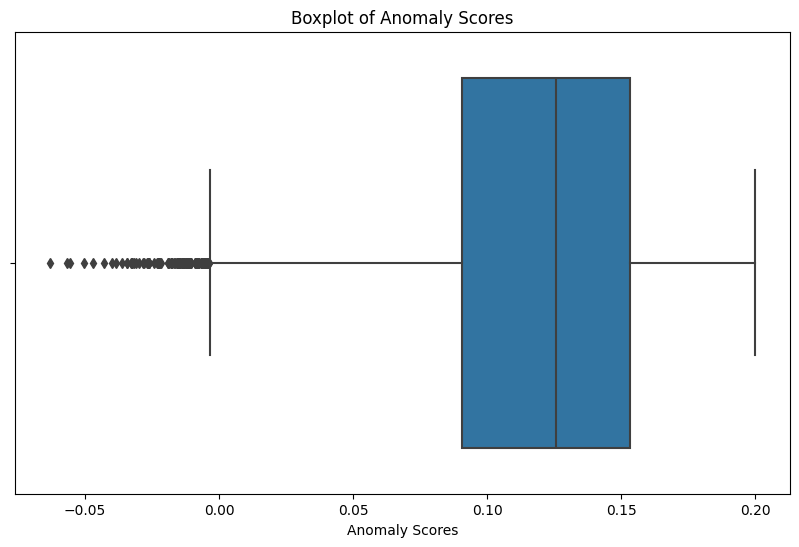

In [89]:
# Boxplot for all data
plt.figure(figsize=(10, 6))
sns.boxplot(x=anomaly_scores)
plt.title('Boxplot of Anomaly Scores')
plt.xlabel('Anomaly Scores')
plt.show()

c:\Users\zippe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


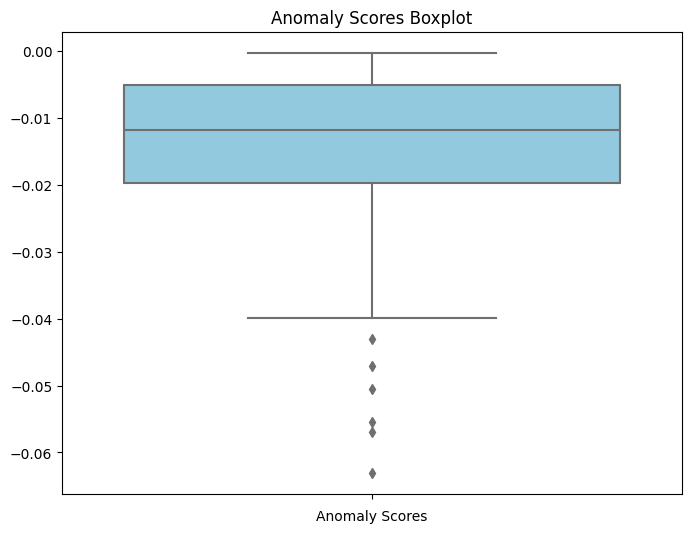

In [77]:
# Plot a boxplot for anomalies
plt.figure(figsize=(8, 6))
sns.boxplot(y=anomaly_scores[anomaly_indexes_array], color='skyblue')
plt.title('Anomaly Scores Boxplot')
plt.xlabel('Anomaly Scores')
plt.show()

In [78]:
# Create ground truth labels for anomalies (1 if anomaly, 0 otherwise)
true_labels = np.zeros(len(y_test))
true_labels[anomaly_indexes_array] = 1

In [79]:
# Map the class labels to "anomaly" and "normal" for true labels
class_labels = {0: 'normal', 1: 'anomaly'}
true_labels_mapped = np.vectorize(class_labels.get)(true_labels)

In [80]:
# Ensure that true_labels_mapped and y_pred are binary (0 or 1)
true_labels_binary = np.where(true_labels_mapped == 'anomaly', 1, 0)

In [81]:
# Calculate metrics
accuracy = accuracy_score(true_labels_binary, prediction == -1)
precision = precision_score(true_labels_binary, prediction == -1)
recall = recall_score(true_labels_binary, prediction == -1)
f1 = f1_score(true_labels_binary, prediction == -1)

In [82]:
# Display metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [83]:
# Classification report
report = classification_report(true_labels_binary, prediction == -1, target_names=['normal', 'anomaly'])

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     13864
     anomaly       1.00      1.00      1.00       136

    accuracy                           1.00     14000
   macro avg       1.00      1.00      1.00     14000
weighted avg       1.00      1.00      1.00     14000



In [84]:
# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(true_labels_binary, anomaly_scores)

# Calculate PR-AUC
pr_auc = auc(recall, precision)

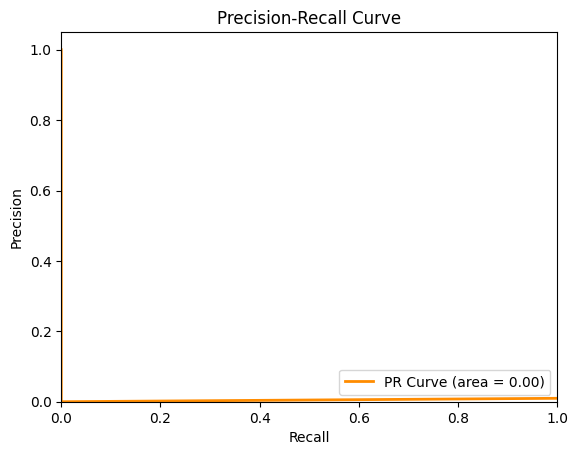

In [85]:
# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

In [86]:
# Get the confusion matrix
conf_matrix = confusion_matrix(true_labels_binary, prediction == -1)

In [87]:
print(conf_matrix)

[[13864     0]
 [    0   136]]


In [88]:
tn, fp, fn, tp = conf_matrix.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 13864
False Positives: 0
False Negatives: 0
True Positives: 136
